# 2022 EY Data Science Challenge
## Model Building - Level 2


| Challenge | Locations                     | Spatial Res        | Species | Satellite Data                                                |
|-----------|-------------------------------|--------------------|---------|---------------------------------------------------------------|
| 1         | Australia                     | Coarse (res=1000)  | Pooled  | Weather Data                                                  |
|***2***    | Australia, Costa Rica         | Moderate (res=100) | Pooled  | Weather Data, Sentinel-2                                      |
| 3         | Australia, Costa Rica,<br>Europe | Fine (res=10)      | Pooled  | Weather Data, Sentinel-2,<br>Land cover, water extent, elevation |


In this notebook, we will develop a model combining weather and Sentinel-2 predictor variables explored in prior notebooks at moderate spatial resolution.


In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Image processing
from scipy.ndimage import convolve

# Geospatial
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point, Polygon
import xarray as xr
import rasterio.features
import rasterio as rio
import fsspec
# import xrspatial.multispectral as ms

# API
import requests
import json

# Import Planetary Computer
import stackstac
import pystac
import pystac_client
import planetary_computer


### Gathering Data for Richmond, NSW

For this demonstration, we will constrain our search to frogs in the Richmond NSW area. 

Text(0.5, 1.0, 'Richmond, NSW')

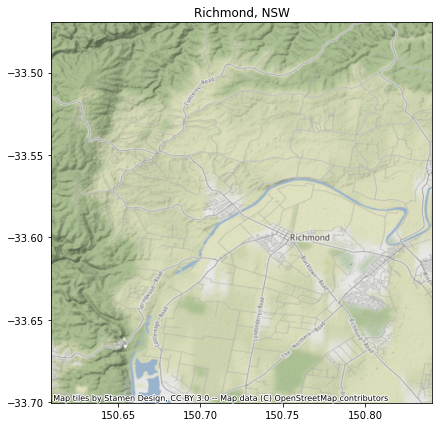

In [2]:
# Richmond, NSW
min_lon, min_lat = (150.62, -33.69)  # Lower-left corner
max_lon, max_lat = (150.83, -33.48)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

# Plot map of region
crs = {'init':'epsg:4326'}
fig, ax = plt.subplots(figsize = (7, 7))
ax.scatter(x=[min_lon, max_lon], y=[min_lat, max_lat], alpha=0)
cx.add_basemap(ax, crs=crs)
ax.set_title('Richmond, NSW')

#### Fetching Frog Response Variable
Firstly, we need to query the GBIF API to obtain the frog occurrence data for the Richmond area. We wrap up this process in the `get_frogs` function. In addition, the process of getting the frog absence data is wrapped up in the `get_frog_absence` data. These two functions combined will get us our response variable dataframe.

In [3]:
def get_frogs(bbox, query_params, crs = {'init':'epsg:4326'}, orderKey="952", verbose=False):
    """Returns the dataframe of frog occurrences for the bounding box specified."""
    
    # Set query parameters
    min_lon, min_lat, max_lon, max_lat = bbox
    limit = 300
    offset = 0
    parameters = {
        **query_params,
        "orderKey":orderKey, # The order Anura (frogs) is indicated by key 952
        "decimalLatitude":f"{min_lat},{max_lat}", # Latitude range
        "decimalLongitude":f"{min_lon},{max_lon}", # Longitude range
        "limit":limit,
        "offset":offset
    }
    
    # Query API
    frogs = pd.DataFrame()
    while True:
        # Fetch results
        parameters['offset'] = offset
        response = requests.get("https://api.gbif.org/v1/occurrence/search", params = parameters).json()
        total = response['count']
        
        # Print progress
        print(f"{offset} of {total}") if verbose else None
        
        # Add results to dataframe
        frogs = frogs.append(
            pd.DataFrame(response['results'])
            [["decimalLatitude", "decimalLongitude"]]
            .assign(
                occurrenceStatus = 1
            )
        )
        if response['endOfRecords']:
            break
        offset += limit
        
    geo_frogs = gpd.GeoDataFrame(
        frogs.reset_index(drop=True), 
        geometry=gpd.points_from_xy(frogs.decimalLongitude, frogs.decimalLatitude),
        crs=crs
    )
    return geo_frogs


In [4]:

def get_frog_absence(geo_frogs, bbox, crs = {'init':'epsg:4326'}, granularity=(50, 50), seed=420):
    """Returns a dataframe complete with frog-absence data"""
    
    # bbox definition
    min_lon, min_lat, max_lon, max_lat = bbox
    
    # Specify granularity of grid (50x50)
    grid = np.array(granularity)

    # Calculate the step required to achieve granularity
    step = np.array([max_lat - min_lat, max_lon - min_lon])/grid

    # Define unit vectors
    up = np.array([0, 1])
    right = np.array([1, 0])

    # Bottom corner of entire bounding box
    bbox_bottom_corner = np.array([min_lon, min_lat])
    
    # bottom corner of grid unit
    bottom_corner = bbox_bottom_corner
    non_frogs = pd.DataFrame()
    for i in range(grid[0]):
        for j in range(grid[1]):

            # Define grid unit
            coords = [
                tuple(bottom_corner), 
                tuple(bottom_corner + step*up), 
                tuple(bottom_corner + step), 
                tuple(bottom_corner + step*right)
            ]
            grid_unit = Polygon(coords)

            # count all frogs that intersect with this region
            num_frogs = sum(geo_frogs.intersects(grid_unit))

            if num_frogs == 0:
                midpoint = bottom_corner + step/2
                non_frogs = non_frogs.append({'decimalLatitude':midpoint[1], 'decimalLongitude':midpoint[0]}, ignore_index=True)

            # move bottom corner to next grid unit
            bottom_corner = bbox_bottom_corner + step*np.array([i, j])
    
    np.random.seed(seed)
    non_frogs = (
        non_frogs
        # Take as many non-frogs as there are frogs
        .sample(len(geo_frogs))
        # Assign new columns
        .assign(
            occurrenceStatus = '0'
        )
        [[ "decimalLatitude", "decimalLongitude", "occurrenceStatus"]]
    )
    
    geo_non_frogs = gpd.GeoDataFrame(
        non_frogs, 
        geometry=gpd.points_from_xy(non_frogs.decimalLongitude, non_frogs.decimalLatitude),
        crs=crs
    )
    
    all_frogs = (
        geo_frogs.append(geo_non_frogs)
        .reset_index(drop=True)
        .reset_index()
        .rename(columns={'index':'key'})
    )
    
    return all_frogs


In [5]:
frog_data = get_frogs(bbox, {"year":"1800,2022"}, verbose=True)
frog_data = get_frog_absence(frog_data, bbox)
frog_data

0 of 1456
300 of 1456
600 of 1456
900 of 1456
1200 of 1456


,key,decimalLatitude,decimalLongitude,occurrenceStatus,geometry
0,0,-33.640336,150.687247,1,POINT (150.68725 -33.64034)
1,1,-33.609240,150.748344,1,POINT (150.74834 -33.60924)
2,2,-33.687430,150.708166,1,POINT (150.70817 -33.68743)
3,3,-33.567792,150.790437,1,POINT (150.79044 -33.56779)
4,4,-33.629142,150.713045,1,POINT (150.71304 -33.62914)
...,...,...,...,...,...
2907,2907,-33.490500,150.739700,0,POINT (150.73970 -33.49050)
2908,2908,-33.540900,150.622100,0,POINT (150.62210 -33.54090)
2909,2909,-33.637500,150.647300,0,POINT (150.64730 -33.63750)
2910,2910,-33.557700,150.722900,0,POINT (150.72290 -33.55770)


#### Fetching predictor variables
Next, we write a function called `get_pc` that will assist us in grabbing each predictor variable from the planetary computer. It will calculate the median mosaic and return it as an xarray object.


In [6]:
def get_terraclimate(bbox, interp_dims=None, assets=['tmax', 'tmin', 'ppt', 'soil'],
        features=['tmax_max', 'tmax_mean', 'tmin_min', 'tmin_mean', 'ppt_mean', 'soil_mean']):
    
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice('2015-01-01','2019-12-31'))
    data = data[assets]
    data = data.rename(lat='y', lon='x').to_array().compute()

    # Calculate metrics
    data_mean = data.mean(dim="time", skipna=True).rename(variable='band')
    data_min = data.min(dim="time", skipna=True).rename(variable='band')
    data_max = data.max(dim="time", skipna=True).rename(variable='band')

    # Combine metrics
    combined_values = np.concatenate(
        (data_mean.values, data_min.values, data_max.values),
        axis=0
    )
    combined_bands = []
    for suffix in ['_mean', '_min', '_max']:
        for band in data_mean.band.values:
            combined_bands.append(band+suffix)
    combined_data = xr.DataArray(
        data=combined_values,
        dims=data_mean.dims,
        coords=dict(
            band=combined_bands,
            y=data_mean.y,
            x=data_mean.x
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        combined_data = combined_data.interp(x=interp_dims[0], y=interp_dims[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

In [7]:
# Function to access the planetary computer
def get_pc(product, bbox, assets={"image/tiff"}, resolution=10, pc_query=None, date_range=None, na_val=None, features=None):
    """Return the median mosaic xarray of a specified planetary computer product for a given location"""
    
    # Query the planetary computer
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(
        bbox=bbox,
        datetime=date_range,
        collections=[product],
        limit=500,  # fetch items in batches of 500
        query=pc_query
    )
    items = list(search.get_items())
    print('This is the number of scenes that touch our region:',len(items))
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]

    # Define the scale according to our selected crs, so we will use degrees
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 
        
    # Stack up the items returned from the planetary computer
    data = (
        stackstac.stack(
            signed_items,
            epsg=4326, # Use common Lat-Lon coordinates
            resolution=scale, # Use degrees for crs=4326
            bounds_latlon = bbox,
            resampling=rio.enums.Resampling.average, # Average resampling method (only required when resolution >10)
            chunksize=4096,
            assets=assets
        )
    )
    
    if na_val is not None:
        data = data.where(lambda x: x != na_val, other=np.nan)
    
    # Median Composite
    median = data.median(dim="time", skipna=True).compute()
    return median

In [8]:
# Define products and query parameters for the planetary computer
products = {
    # Sentinel-2 Spectral Band data
    'sentinel-2-l2a':{
        "resolution":100,
        'assets':["B04", "B03", "B02", "B08"],
        'pc_query':{"eo:cloud_cover": {"lt": 20}},
        'date_range':"2020-01-01/2020-12-31",
        'na_val':0
    },
    # Weather - can not be loaded first! Need prior dimensions to use in interpolation
    "terraclimate":{
        'assets':['tmax', 'tmin', 'ppt', 'soil'],
        'features':['tmax_max', 'tmax_mean', 'tmin_min', 'tmin_mean', 'ppt_mean', 'soil_mean']
    }
}

x_dim = None
y_dim = None
def get_predictor_datasets(products, bbox, product_names={"cop-dem-glo-30":'elevation',"io-lulc":'landcover'}):
    """Fetch and collect all products"""
    all_datasets = []
    for i, (product, params) in enumerate(products.items()):
        print(f'loading {product}')
        
        # Interpolate the weather data to 10m resolution
        if product == 'terraclimate':
            data = get_terraclimate(bbox, (x_dim, y_dim), **params)
        else:
            data = get_pc(product, bbox, **params)

        # Rename bands of those with only one band (which otherwise defaults to generic 'data')
        if data.shape[0] == 1:
            if product in product_names.keys():
                data = data.assign_coords(band=[product_names[product]])

        # Collect all datasets in a list
        all_datasets.append(data)

        # Calculate the gradient of the elevation data
        if product == 'cop-dem-glo-30':
            data_elevation = data.squeeze().drop("band")
            slope_vals = slope_pct(data_elevation, products[product]['resolution'])
            data_slope = xr.DataArray(
                np.expand_dims(slope_vals, 0),
                coords=dict(
                    band=['gradient'],
                    y=data_elevation.y,
                    x=data_elevation.x
                )
            )
            all_datasets.append(data_slope)
            
        # Save dimensions for terraclimate interpolation
        x_dim = data.x
        y_dim = data.y
            
    return all_datasets

all_datasets = get_predictor_datasets(products, bbox)

loading sentinel-2-l2a
This is the number of scenes that touch our region: 61
loading terraclimate


#### Stitching together all predictor variables

In [9]:
def create_predictor_image(all_datasets):
    """Returns one xarray with concatenated bands

    Arguments:
    all_datasets -- list of xarrays of dimensions, where the ith array has dimensions (k_i, n, m). 
    """
    # Combine datasets into one multi-band image
    for i, data in enumerate(all_datasets):
        print(f"Combining dataset {i+1} of {len(all_datasets)}")
                
        if i == 0:
            combined_values = data.values
            combined_bands = data.band.values
            x_coords = data.x
            y_coords = data.y
            dims = data.dims
        else:
            combined_values = np.concatenate((combined_values, data.values), axis=0)
            combined_bands = np.concatenate((combined_bands, data.band.values))

    predictor_image = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            x=x_coords,
            y=y_coords
        )
    )
    return predictor_image

In [10]:
predictor_image = create_predictor_image(all_datasets)
predictor_image.band.values

Combining dataset 1 of 2
Combining dataset 2 of 2


array(['B04', 'B03', 'B02', 'B08', 'tmax_max', 'tmax_mean', 'tmin_min',
       'tmin_mean', 'ppt_mean', 'soil_mean'], dtype='<U9')

##### Joining Features to Response Variable

Now that we have read in both our response and predictor variables, we now need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [11]:
def join_features(model_data, predictor_image):
    """Joins the features from each feature dataset onto each response variable. 

    Arguments:
    model_data -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    all_datasets -- list of feature datasets stored as xarray dataarrays, indexed with geocoordinates
    """
    # For each latitude and longitude coordinate, find the nearest predictor variable pixel values
    data_per_point = pd.DataFrame()
    for j, (lon, lat, key) in enumerate(zip(model_data.decimalLongitude, model_data.decimalLatitude, model_data.key)):
        # Print out some progress markers
        if (j+1)%500==0:
            print(f"{j+1} of {len(model_data)}")

        # Get the predictor pixel at the site of the frog occurrence
        nearest_point = predictor_image.sel(x=lon, y=lat, method="nearest")

        # Prepare values and columns and save them in a dataframe, saving the join key for later reference
        values = np.concatenate((np.squeeze(nearest_point.values), np.array([key])))
        columns = list(nearest_point.band.values) + ['key']
        data_per_point = data_per_point.append(
            pd.DataFrame(
                np.array([values]), 
                columns=columns
            )
        )

    # Join the predictor variables we just collected back onto the frog data
    model_data = model_data.merge(
        data_per_point,
        on = ['key'],
        how = 'inner'
    )
        
    return model_data

model_data = join_features(frog_data, predictor_image)
model_data.head()

500 of 2912
1000 of 2912
1500 of 2912
2000 of 2912
2500 of 2912


,key,decimalLatitude,decimalLongitude,occurrenceStatus,geometry,B04,B03,B02,B08,tmax_max,tmax_mean,tmin_min,tmin_mean,ppt_mean,soil_mean
0,0,-33.640336,150.687247,1,POINT (150.68725 -33.64034),346.0,325.0,208.0,1866.0,32.700005,24.691673,2.299999,11.318333,59.716667,31.700001
1,1,-33.609240,150.748344,1,POINT (150.74834 -33.60924),794.0,822.0,595.0,2416.0,32.900002,24.811666,2.400002,11.521669,59.566666,31.000000
2,2,-33.687430,150.708166,1,POINT (150.70817 -33.68743),492.0,562.0,306.0,2592.0,32.900002,24.829996,2.600002,11.555004,59.866665,31.983334
3,3,-33.567792,150.790437,1,POINT (150.79044 -33.56779),514.0,676.0,361.0,3448.0,32.700005,24.668339,2.600002,11.516669,60.466667,31.316668
4,4,-33.629142,150.713045,1,POINT (150.71304 -33.62914),536.0,501.0,306.0,1920.0,32.800003,24.720001,2.400002,11.513337,59.916668,31.716667


#### Model Training

Now that we have the data in a format appropriate for machine learning, we can begin training a model. For this demonstration notebook, we will use a basic logistic regression model from the [scikit-learn](https://scikit-learn.org/stable/) library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customisation capabilities.

Scikit-learn models require separation of predictor variables and the response variable. We store the predictor variables in dataframe `X` and the response in the array `y`. We must make sure to drop the response variable from `X`, otherwise the model will have the answers! It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.

In [12]:
from sklearn.linear_model import LogisticRegression

full_model = LogisticRegression()
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['key', 'decimalLongitude', 'decimalLatitude', 'occurrenceStatus', 'geometry'], 1)
)
y = model_data.occurrenceStatus.astype(int)


For now, we will train the model using all of our training data. Hence, this section will only reflect the in-sample performance of our model, and not the out-of-sample performance. Out-of-sample performance is crucial in estimating how a model will perform in a real world environment. We will attempt to evaluate the out-of-sample performance of this model in a later section, but for now we can have some fun visualising the in-sample performance for Richmond, NSW.

In [13]:
full_model.fit(X, y)

LogisticRegression()

#### Model Prediction

Logistic regression is a machine learning model that estimates the probability of a binary response variable. In our case, the model will output the probability of a frog being present at a given location. To visualise this, we need to understand that each pixel on our satellite image has an associated $k$ dimensional vector of predictor variable values, in this case $k=13$ bands relating to elevation data, landcover, JRC water extent, and Sentinel-2 data. Thus, we can associate a $k$ band image with any satellite image. For each of those $k$ band pixels, we can use our logistic regression model to output the probability of a frog being found there. Finally, we can visualise this as a heatmap which will show regions that our model thinks are likely frog habitats.


##### Heat Map
Above, we stitched together each predictor variable into a $k$ band image using the `create_predictor_image` function. Now, we will define another function called `predict_frogs` that will take this image in, along with our logistic regression model, and output the probabilities for each pixel.


In [14]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("x", "y")).transpose()
    
    # Calculate probability for each pixel point 
    probabilities = model.predict_proba(
        predictor_image
    )

    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]

    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

In [15]:
# Calculate probability for each pixel point 
resultant_image = predict_frogs(predictor_image, full_model)

Now that we have successfully created a one-band image of probabilities, all that is left is to visualise it. To do this, we write a function to plot a heatmap of probabilities. In addition to the heatmap, we will also plot the actual map of the area in question, and the binary classification regions of the probability heatmap. The latter is simply a binary mask of the probability heatmap, 1 where the probability is greater than 0.5 and 0 elsewhere. 

To help visualise the effectiveness of our model, we plot the frog occurrences over top of each image. This can give us an idea of where our model is doing well, and where it is doing poorly.



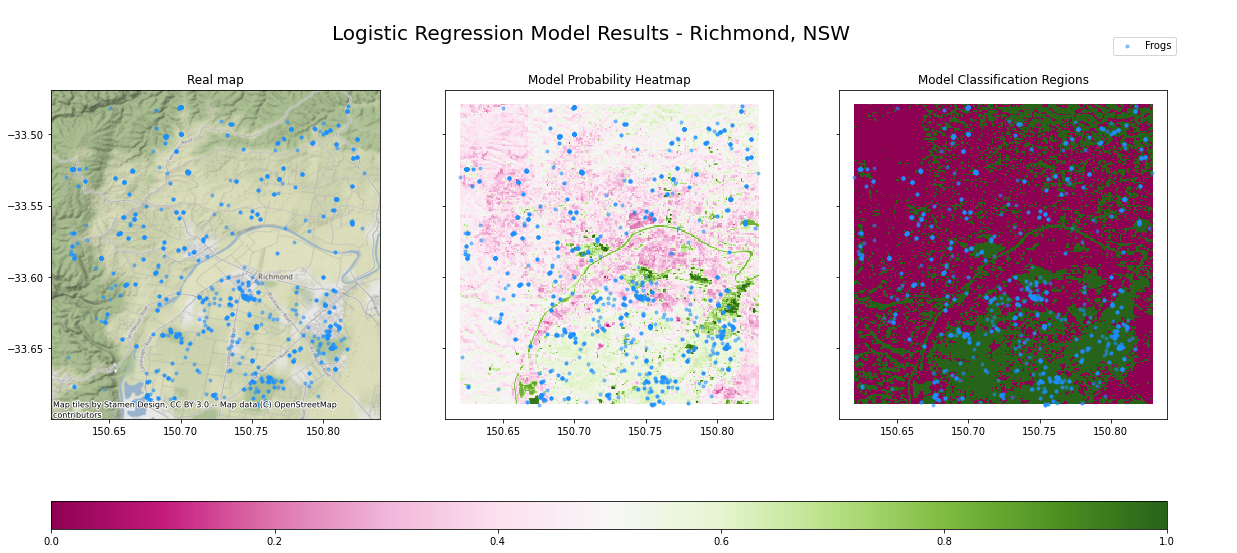

In [16]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    
    bbox = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]

    # Plot real map
    ax[0].scatter(x=[bbox[0], bbox[1]], y=[bbox[2], bbox[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')

    # Plot heatmap from model
    heatmap = ax[1].imshow(
        resultant_image.transpose(), cmap='PiYG', vmin=0, vmax=1.0, interpolation='none', extent=bbox
    )
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = ax[2].imshow(
        resultant_image.transpose() > 0.5, cmap='PiYG', vmin=0, vmax=1.0, interpolation='none', extent=bbox
    )
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, color = 'dodgerblue', marker='.', alpha=0.5, label='Frogs' if i==0 else '')

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    

plot_heatmap(resultant_image, frog_data, "Logistic Regression Model Results - Richmond, NSW")

#### In-Sample Evaluation

Now that we have visualised the model on the Richmond area, we can calculate some performance metrics to guage the effectiveness of the model. Again, it must be stressed that this is the in-sample performance - the performance on the training set. Hence, the values will tend to overestimate its performance -  so don't get too excited!


In [17]:
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay

predictions = full_model.predict(X)

print(f"F1 Score: {f1_score(y, predictions)}")
print(f"Accuracy: {accuracy_score(y, predictions)}")

F1 Score: 0.62663906142167
Accuracy: 0.6284340659340659


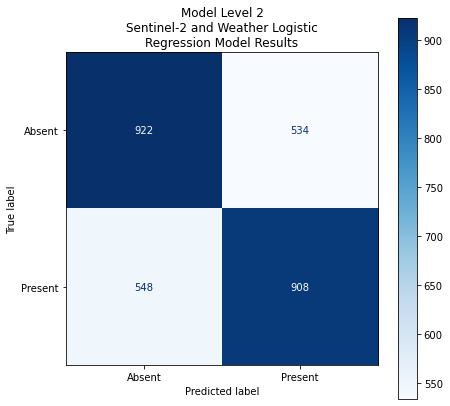

In [18]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 2\nSentinel-2 and Weather Logistic\nRegression Model Results')
plt.show()

#### Out-of-sample evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalise. This is because models have a tendancy to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will use k-fold cross-validation. This technique involves splitting the training dataset into folds, in this case we will use 10. Each iteration, the model is trained on all but one of the folds, which is reserved for testing. This is repeated until all folds have been left out once. At the end of the process, we will have 10 metrics which can be averaged, giving a more reliable and valid measure of model performance. 

`Scikit-learn` has built-in functions that can assist in k-fold cross validation. In particular, we will use `StratifiedKFold` to split our data into folds, ensuring there is always a balanced number of frogs and non-frogs in each fold.


In [19]:
from sklearn.model_selection import StratifiedKFold

cv_model = LogisticRegression()

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        results[metric].append(fn(y_test, predictions))
        
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in results.items():
    print(f"{metric}: {np.mean(result).round(2)}")
    


Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.63
Accuracy: 0.63


### Testing model on an arbitrary area 

Now that we have generated a model using data from one area, how do we apply that model to other areas? To do this, we need to write some functions that will allow us to automatically pull the required data for an arbitrary location. Specifically, we need to be able to pull all the predictor variables for a given location, as well as the actual frog sightings in that location for reference. These functions will reuse much of the code from prior notebooks, so we won't go into too much detail.


#### Query the Hornsby Area

For this, we will use Hornsby, NSW as an example.

Text(0.5, 1.0, 'Berowra Valley National Park, Hornsby NSW')

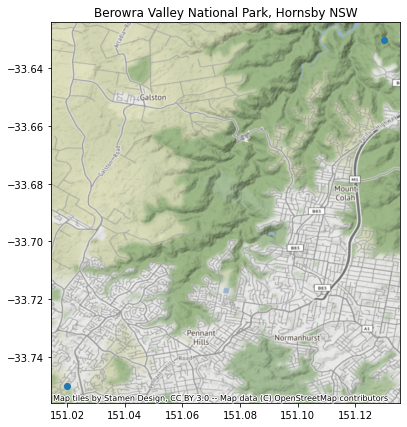

In [20]:
# Hornsby
min_lon, min_lat = (151.02, -33.75)  # Lower-left corner
max_lon, max_lat = (151.13, -33.63)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)


fig, ax = plt.subplots(figsize = (7, 7))
ax.scatter(x=[min_lon, max_lon], y=[min_lat, max_lat])
cx.add_basemap(ax, crs=crs)
ax.set_title("Berowra Valley National Park, Hornsby NSW")

Firstly, we grab all frog occurrences in the area from 1800 until 2022.

In [21]:
hornsby_frogs = get_frogs(bbox, {"year":"1800,2022"}, verbose=True)

0 of 3001
300 of 3001
600 of 3001
900 of 3001
1200 of 3001
1500 of 3001
1800 of 3001
2100 of 3001
2400 of 3001
2700 of 3001
3000 of 3001


Next, we obtain the predictor variables from the planetary computer.

In [22]:
# Define products and query parameters for the planetary computer
hornsby_datasets = get_predictor_datasets(products, bbox)

loading sentinel-2-l2a
This is the number of scenes that touch our region: 49
loading terraclimate


Finally, we can use the `create_predictor_image` and `predict_frogs` functions from before to create the probability heatmap of the new area.

In [23]:
hornsby_predictor_image = create_predictor_image(hornsby_datasets)
hornsby_resultant_image = predict_frogs(hornsby_predictor_image, full_model)

Combining dataset 1 of 2
Combining dataset 2 of 2


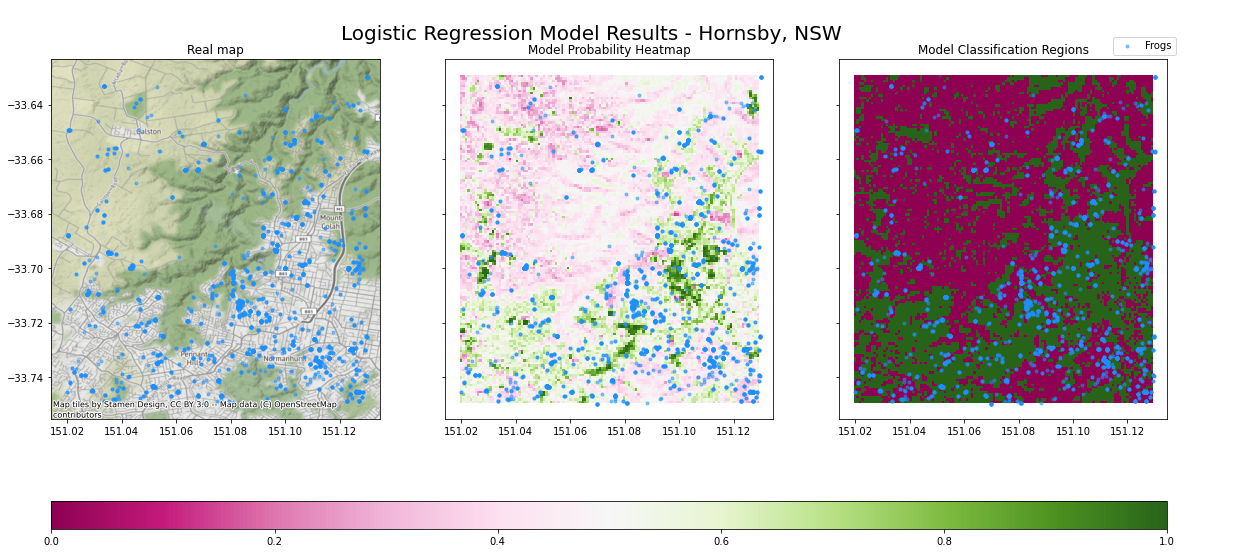

In [24]:
# Display the image
plot_heatmap(hornsby_resultant_image, hornsby_frogs, "Logistic Regression Model Results - Hornsby, NSW")